Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores parámetros encontrados: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}

ROC AUC: 0.6902
Average Precision: 0.6673

Umbral F1-óptimo: 0.3413
   Precision: 0.5725, Recall: 0.8829, F1: 0.6946

Reporte con umbral F1-óptimo:
              precision    recall  f1-score   support

           0       0.74      0.34      0.47      1965
           1       0.57      0.88      0.69      1964

    accuracy                           0.61      3929
   macro avg       0.66      0.61      0.58      3929
weighted avg       0.66      0.61      0.58      3929



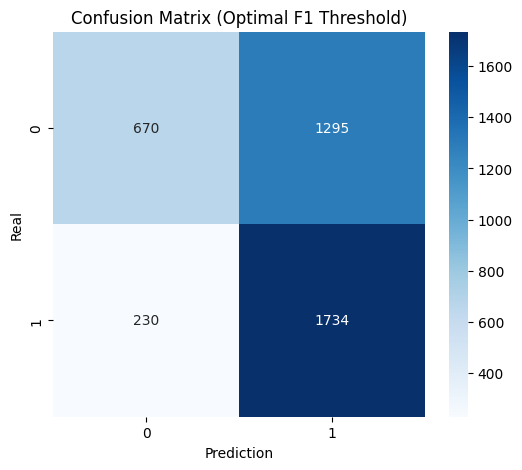

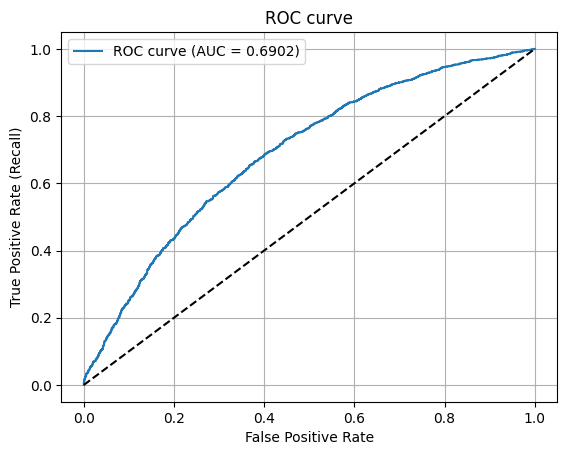

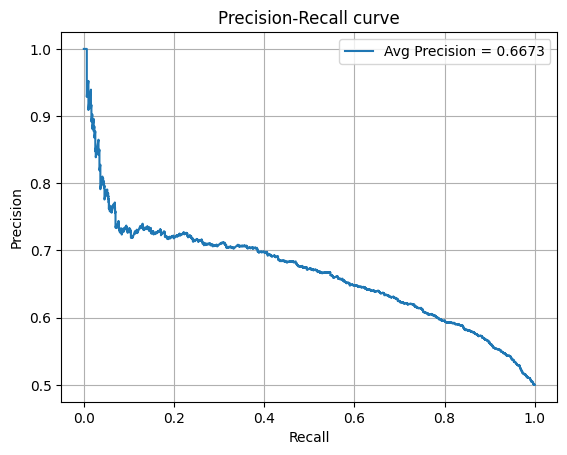

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix, roc_curve, auc, f1_score
)
from sklearn.utils import resample
from xgboost import XGBClassifier
import joblib

# =====================
# 1. Cargar y preparar datos
# =====================

df = pd.read_csv('data/variables.csv')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

drop_unwanted = [
    'ETNIA', 'ADEUDO', 'PUNTAJE_ADM', 'CAMBIO_PROGRAMA', 'CARRERA', 'Año', 'Latitud', 'Longitud', 'BACH_PROMEDIO', 'EDAD',
    'SEMESTRE PLAN', 'ÚLTIMO PERIODO CURSADO', 'SEMESTRE ABANDONO', 'NIVEL_CARRERA','CATEGORIA_CARRERA'
]
features = [c for c in numeric_cols if c not in drop_unwanted + ['DESERCION']]

# Entrenamiento: 2014–2022
df_train = df[df['Año'].between(2014, 2022)].copy()
predict = df[df['Año'].isin([2023, 2024])].copy()

# Preservar EMPLID solo en el conjunto predict
ids_pred = predict[['EMPLID', 'Año']]
predict = predict[features + ['DESERCION']]  # <- Asegurar consistencia

# Corregido: usar df_train en lugar de train
df_train.drop(columns=['Año'], inplace=True) # <- EMPLID se mantiene pero no se usa

# Preparar X e Y, excluyendo EMPLID
X = df_train[[c for c in features if c != 'EMPLID']]  # Variables predictoras con Exclusión explícita
y = df_train['DESERCION'] # Variable objetivo

# Submuestreo aleatorio para balancear clases
data = pd.concat([X, y], axis=1)
desertores = data[data['DESERCION'] == 1]
no_desertores = data[data['DESERCION'] == 0]
no_desertores_down = resample(no_desertores, replace=False, n_samples=len(desertores), random_state=42)
balanced_data = pd.concat([desertores, no_desertores_down])

X_bal = balanced_data[[c for c in features if c != 'EMPLID']]  # Asegurar consistencia en features
y_bal = balanced_data['DESERCION']

# Dividir entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42)

# =====================
# 2. Definir Pipeline y GridSearch
# =====================

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
])

param_grid = {
    'xgb__n_estimators': [200],
    'xgb__max_depth': [7],
    'xgb__learning_rate': [0.05],
    'xgb__subsample': [0.8],
    'xgb__colsample_bytree': [0.8],
    'xgb__scale_pos_weight': [1]  # ya está balanceado
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid.best_params_)

# =====================
# 3. Evaluación y ajuste de umbral F1-óptimo
# =====================

model = grid.best_estimator_
y_proba = model.predict_proba(X_test)[:, 1]

# Métricas probabilísticas
roc_auc = roc_auc_score(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

print(f"\nROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_prec:.4f}")

# Encontrar umbral óptimo por F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
thresholds = thresholds[:-1]
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"\nUmbral F1-óptimo: {best_threshold:.4f}")
print(f"   Precision: {precision[best_index]:.4f}, Recall: {recall[best_index]:.4f}, F1: {f1_scores[best_index]:.4f}")

# Aplicar el umbral ajustado
y_pred_adjusted = (y_proba >= best_threshold).astype(int)

# =====================
# 4. Reporte y visualización
# =====================

print("\nReporte con umbral F1-óptimo:")
print(classification_report(y_test, y_pred_adjusted))

cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Optimal F1 Threshold)")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.grid(True)
plt.legend()
plt.show()

# Curva Precision-Recall
plt.figure()
plt.plot(recall, precision, label=f"Avg Precision = {avg_prec:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.grid(True)
plt.legend()
plt.show()

# =====================
# 5. Guardar modelo y el umbra optimo 
# =====================
joblib.dump(model, "modelo_xgboost_f1opt.joblib")

pd.DataFrame({
    "probabilidad": y_proba,
    "prediccion_ajustada": y_pred_adjusted,
    "real": y_test.values
}).to_csv("predicciones_ajustadas_f1.csv", index=False)

with open("umbral_f1.txt", "w") as f:
    f.write(str(best_threshold))


=== Top 15 Variables Más Importantes ===
                              feature  importance
66                                age    0.035995
55                high-school_average    0.031307
65                 conditioned_career    0.029802
34                civil_family_burden    0.020566
22      academic_progress_performance    0.019475
0                     economic_burden    0.018757
50                   public transport    0.018250
2                         tuition_fee    0.017415
39                lifestyle_free_time    0.017378
35  educational_capital_father_mother    0.016986
64           work-career_relationship    0.016567
62                sporadic_work_shift    0.016531
52            non-motorized_transport    0.016406
9                 economic constraint    0.016363
24        physical_teaching_resources    0.016299


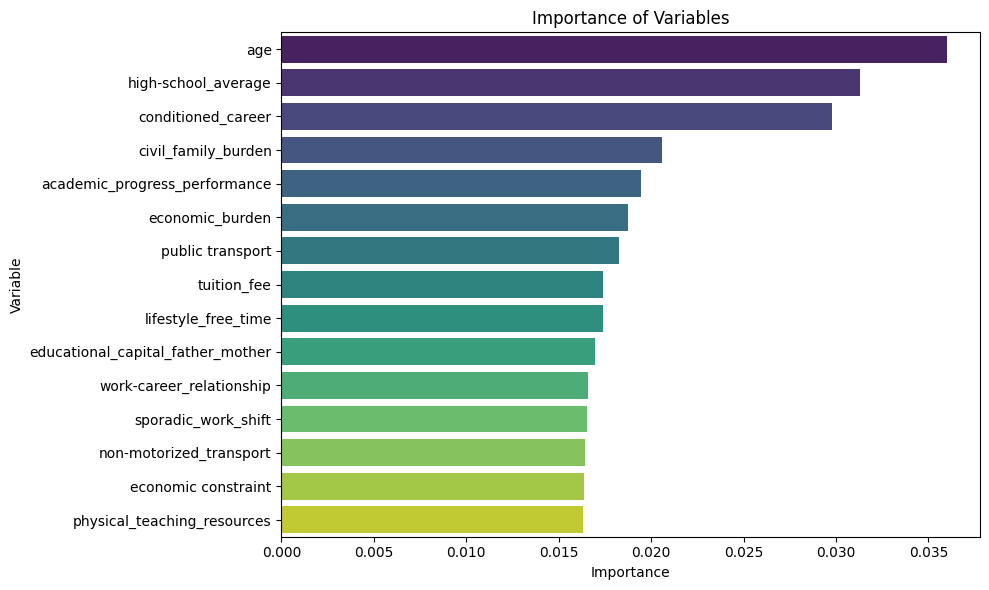


Variables seleccionadas: ['age', 'high-school_average', 'conditioned_career', 'civil_family_burden', 'academic_progress_performance', 'economic_burden', 'public transport', 'tuition_fee', 'lifestyle_free_time', 'educational_capital_father_mother', 'work-career_relationship', 'sporadic_work_shift', 'non-motorized_transport', 'economic constraint', 'physical_teaching_resources', 'evening_work_shift', 'weekend_work_shift', 'personal_limitation', 'night_shift_work', 'career_satisfaction', 'university_transfer_time', 'public_institution', 'economic_restriction', 'financial_independence', 'distance_campus', 'private_institution', 'goods_services_housing', 'vocational_influence', 'mixed_work_shift', 'intensity_tobacco_alcohol_consumption', 'work_field_private_entrepreneur', 'schooled_institution', 'techniques_study_organization', 'public_institutional_labor_scope', 'educational_parental_assessment', 'institutional_recreational_services', 'prestige_quality', 'passive teaching', 'academic_limi

In [2]:
#  IMPORTANCIA DE VARIABLES
# El modelo está guardado en 'model' (grid.best_estimator_), no en 'modelo_final'
xgb_model = model.named_steps["xgb"]
feature_importances = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\n=== Top 15 Variables Más Importantes ===")
print(feature_importances.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(15), x="importance", y="feature", hue="feature", palette="viridis", legend=False)
plt.title("Importance of Variables")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Seleccionar variables con importancia >= 0.001
umbral = 0.001
selected_features = feature_importances[feature_importances['importance'] >= umbral]['feature'].tolist()
print("\nVariables seleccionadas:", selected_features)

In [3]:
#  Guardar las variables seleccionadas en un archivo

import joblib

# Guardar como archivo binario (pickle)
joblib.dump(selected_features, "variables_seleccionadas.pkl")

['variables_seleccionadas.pkl']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=24fa97d8-6b94-4f62-a2dc-97416a953ae1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>